In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import os
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing


In [2]:
# Import data (for Mac the "\\" might be replaced by "/")
cwd = os.getcwd()
data = pd.read_csv(cwd + "\\WA_Fn-UseC_-Sales-Win-Loss.csv", index_col = 0)

First do data preparation the Xiao way **except standardization which is not required for Random Forest.**

In [3]:
# Data Preparition
data_clean = data.copy()
# Drop rows with opportunity amount 0
data_clean = data_clean.drop(data_clean[data_clean['Opportunity Amount USD'] == 0].index, axis = 0)
# Drop features that should not be used in training and prediction
data_clean = data_clean.drop(['Sales Stage Change Count', 'Elapsed Days In Sales Stage', 
                              'Ratio Days Identified To Total Days',
                              'Ratio Days Qualified To Total Days', 'Ratio Days Validated To Total Days', 
                              'Total Days Identified Through Closing', 'Total Days Identified Through Qualified',
                              'Deal Size Category'], 
                             axis = 1)
# Change opportunity result(our target variable) to numeric
minority = data_clean['Opportunity Result'].value_counts().idxmin()
result = np.array((data_clean['Opportunity Result'] == minority).astype(int))
data_clean = data_clean.drop(['Opportunity Result'], axis = 1)
# For each categorical variables in the dataset, try to assign an unique indicator variable 
#      for each different category
# (This may not be a good step because it adds too many columns, but we'll see)
for col in data_clean.columns:
    if is_string_dtype(data_clean[col]):
        name_set = set(data_clean[col])
        for name in name_set:
            data_clean[' '.join([col, name, 'indicator'])] = (data_clean[col] == name).astype(int)
        data_clean = data_clean.drop([col], axis = 1)
# Check if there is any null value in our dataset
if data_clean.isnull().any().any():
    print('NO!!!!!')
# Gladly, we don't have any

data_clean['result'] = result

In [5]:
# Split data into training and test (Xiao's version)
length = len(data_clean['result'])
train_index = []
test_index = []
for i in range(length):
    train_index.append(i) if np.random.rand() <= 0.8 else test_index.append(i)
data_train = data_clean.iloc[train_index, :]
data_test = data_clean.iloc[test_index, :]

In [7]:
# Create a baseline model and set the random state for reproductibility
rf = RandomForestClassifier(random_state=42)

from pprint import pprint
# Look at the default parameters
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [8]:
# Create a parameter grid to sample from during fitting

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', "log2", None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               "criterion": criterion}
pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


### Doing random grid in combination with grad seach
First, we will do random grid: From the defined range of parameter, it trains n random combinations of those parameters and chooses the best.

As such, it needs less time and it narrows the area of parameter values, where to perform the grid search.

In [10]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV
import time

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
start = time.time()

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(data_train.drop("result", 1), data_train['result'])

end = time.time()
print('Time taken in random grid: {0: .2f}'.format(end - start))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 11.9min finished


Time taken in random grid:  743.07


In [11]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': 30,
 'criterion': 'entropy',
 'bootstrap': True}

In [16]:
# Train a first model with these parameters
rf_1 = rf_random.best_estimator_
rf_1.fit(data_train.drop("result", 1), data_train['result'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
# Make prediction
rf_1_pred = rf_1.predict_proba(data_test.drop("result", 1))

In [23]:
# Get AUC
roc_auc_score(data_test["result"], rf_1_pred[:,1])

0.8409171411076852

#### Now additionaly do grid search in the area of the reported best parameters from random grid

In this section you would have to adjust the parameter values based on the results from the grid search.

In [25]:
# Now additionaly do grid search in the area of the reported best parameters from random grid
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
search_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 40, 50],
    'max_features': [2, 3, None],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [80, 100, 200, 400]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = search_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
start = time.time()
grid_search.fit(data_train.drop("result", 1), data_train['result'])
end = time.time()
print('Time taken in random grid: {0: .2f}'.format(end - start))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 51.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 97.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 147.5min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 190.9min finished


Time taken in random grid:  11564.93


In [28]:
# Look at optimal parameters
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 400}

In [29]:
# Train the model on these
rf_2 = grid_search.best_estimator_
rf_2.fit(data_train.drop("result", 1), data_train['result'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [30]:
# Make prediction
rf_2_pred = rf_2.predict_proba(data_test.drop("result", 1))

In [31]:
# Get AUC
roc_auc_score(data_test["result"], rf_2_pred[:,1])

0.844561554095254

In [32]:
# Now plot the ROCs

# Use Xiaos function
def plotROC(preds, truth, name):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    # chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create the plot
    plt.plot(fpr, tpr, color = c, label = name + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    return roc_auc

0.844561554095254

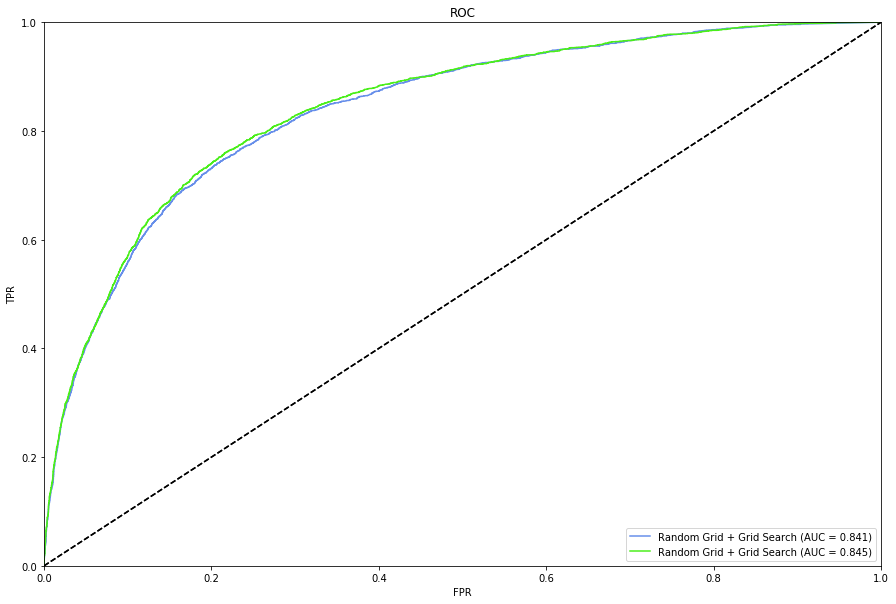

In [37]:
# Plot ROCs
fig = plt.figure(figsize = (15, 10))
plotROC(rf_1_pred[:,1], data_test['result'], 'Random Grid + Grid Search')
plotROC(rf_2_pred[:,1], data_test['result'], 'Random Grid + Grid Search')